In [1]:
#!pip install scikeras
#!pwd
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

2024-10-22 22:21:26.001334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import roc_curve, auc
import joblib

#import warnings

#warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer")

# Chargement des données prétraitées
df = pd.read_csv('../data/processed/data.csv', sep='\t')
df = df.astype(int)

# Pour essais préalables et mise au point
#df = df.sample(1000)

# Séparation des features et de la variable cible
X = df.drop('grav_grave', axis=1)
y = df['grav_grave']

# Division en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "acc_scaler.mdl")

['acc_scaler.mdl']

In [3]:
# Obtenir le nombre correct de features
input_shape = X_train_scaled.shape[1]

# Fonction pour construire le modèle Keras
def create_model(optimizer='adam', init='glorot_uniform'):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,), kernel_initializer=init),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_initializer=init),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_initializer=init),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Création d'un wrapper KerasClassifier pour utiliser GridSearchCV
model = KerasClassifier(
    build_fn=create_model,
    verbose=0,
    optimizer='adam',
    epochs=50,
    batch_size=32,
    #model__init='glorot_uniform'
)

# Définition des hyperparamètres à tester avec GridSearchCV
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 50],
    'optimizer': ['adam', 'rmsprop'],
    #'model__init': ['he_normal', 'he_uniform']
}

# Configuration de GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs = -1)

# Entraînement du modèle avec recherche des hyperparamètres
grid_result = grid.fit(X_train_scaled, y_train)

# Affichage des meilleurs paramètres et score
print(f"Best score: {grid_result.best_score_:.4f}, using Best parameters: {grid_result.best_params_}")
print()

# Création d'un modèle Keras avec les meilleurs paramètres
best_params = grid_result.best_params_
# best_model = create_model(optimizer=best_params['optimizer'], init=best_params['model__init'])
best_model = create_model(optimizer=best_params['optimizer'])

# Entraînement du meilleur modèle
history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1)

# Évaluation sur l'ensemble de test
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, zero_division=0))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

# Calculer et afficher le score AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"\nAUC-ROC Score: {roc_auc:.4f}")

2024-10-22 22:21:39.686002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 22:21:39.804267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 22:21:39.809241: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 22:21:39.830587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 22:21:39.838467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 22:21:39.857018: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-22 22:21:39.895934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic libr

Best score: 0.7805, using Best parameters: {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}

Epoch 1/50
3553/3553 [==============================] - 10s 3ms/step - loss: 0.5600 - accuracy: 0.7114 - val_loss: 0.4709 - val_accuracy: 0.7760
Epoch 2/50
3553/3553 [==============================] - 9s 3ms/step - loss: 0.4843 - accuracy: 0.7718 - val_loss: 0.4636 - val_accuracy: 0.7783
Epoch 3/50
3553/3553 [==============================] - 9s 2ms/step - loss: 0.4728 - accuracy: 0.7773 - val_loss: 0.4615 - val_accuracy: 0.7807
Epoch 4/50
3553/3553 [==============================] - 9s 2ms/step - loss: 0.4671 - accuracy: 0.7812 - val_loss: 0.4589 - val_accuracy: 0.7812
Epoch 5/50
3553/3553 [==============================] - 9s 2ms/step - loss: 0.4658 - accuracy: 0.7807 - val_loss: 0.4626 - val_accuracy: 0.7812
Epoch 6/50
3553/3553 [==============================] - 8s 2ms/step - loss: 0.4601 - accuracy: 0.7832 - val_loss: 0.4581 - val_accuracy: 0.7830
Epoch 7/50
3553/3553 [===============

In [4]:
from tensorflow import keras
import io

# Ecrire tous les résultats dans un fichier txt
with open('results_output.txt', 'w', encoding='utf-8') as f:
    # Écrire les meilleurs paramètres
    f.write(f"Best score: {grid_result.best_score_:.4f}, using Best parameters: {grid_result.best_params_}\n\n")

    # Écrire les résultats de l'entraînement
    f.write(f"Test loss: {test_loss:.4f}\n")
    f.write(f"Test accuracy: {test_accuracy:.4f}\n\n")

    # Écrire le rapport de classification
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred_class, zero_division=0))
    f.write("\n")
    
    # Écrire la matrice de confusion
    f.write("Confusion Matrix:\n")
    f.write(str(confusion_matrix(y_test, y_pred_class)))
    f.write("\n")
    
    # Écrire le score AUC-ROC
    f.write("\n")
    f.write(f"AUC-ROC Score: {roc_auc:.4f}\n")

print("Tous les résultats ont été enregistrés dans 'results_output.txt'")

Tous les résultats ont été enregistrés dans 'results_output.txt'


In [5]:
best_model.save("acc_DeepLearning.h5")

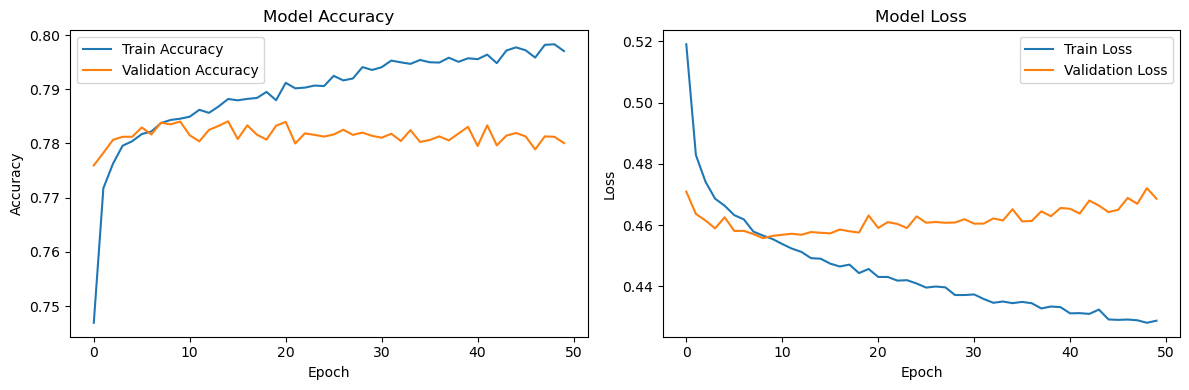

In [6]:
# Tracé de l'historique d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

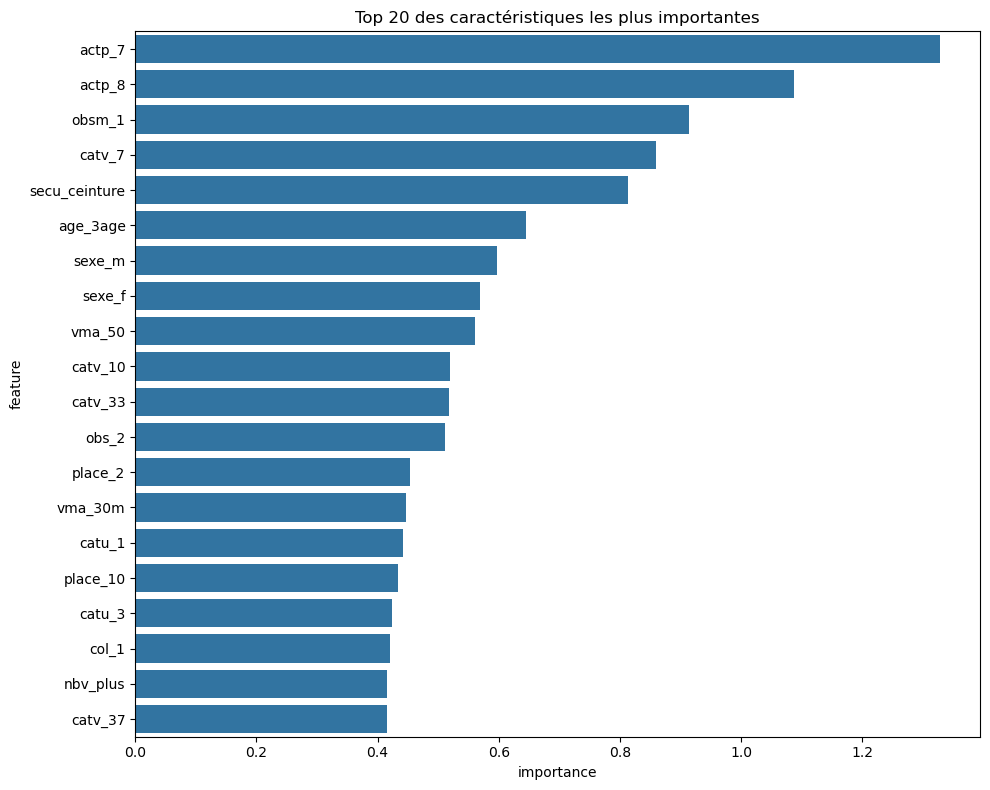

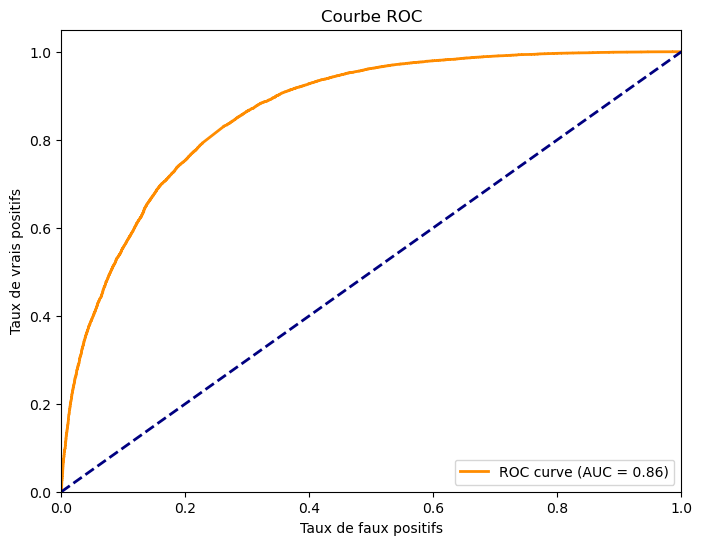

In [7]:
# Fonctions d'analyse et de visualisation

def get_feature_importance(model, feature_names):
    weights = model.layers[0].get_weights()[0]
    importance = np.mean(np.abs(weights), axis=1)
    return dict(zip(feature_names, importance))

def plot_feature_importance(importance_dict, top_n=20):
    feature_importance = pd.DataFrame({'feature': list(importance_dict.keys()), 'importance': list(importance_dict.values())})
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Top {top_n} des caractéristiques les plus importantes')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

# Utilisation des fonctions d'analyse et de visualisation

# Importance des features
importance_dict = get_feature_importance(best_model, X.columns)
plot_feature_importance(importance_dict)

# Courbe ROC
y_pred_proba = best_model.predict(X_test_scaled).ravel()
plot_roc_curve(y_test, y_pred_proba)

/home/manu/devtools/anaconda3/envs/ghi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [20:52<00:00, 12.52s/it]


Shape of shap_values: (100, 264, 1)
Shape of X_test_sample: (100, 264)


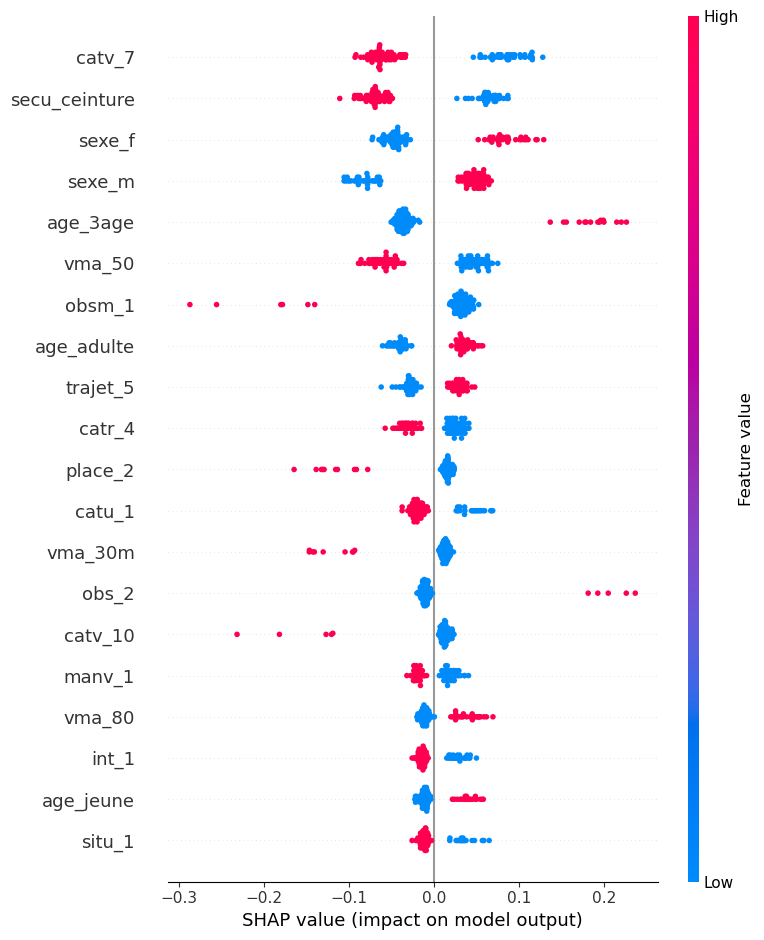

In [8]:
# ! cat "y"|conda install shap
import shap

# Définir une fonction de prédiction pour le KernelExplainer
def f(X):
    return best_model.predict(X)

# Créer un explainer SHAP
background = shap.sample(X_train_scaled, 100)  # Échantillon de background
explainer = shap.KernelExplainer(f, background)

# Calculer les valeurs SHAP pour un sous-ensemble de l'ensemble de test
sample_size = min(100, X_test_scaled.shape[0])  # Prendre au maximum 100 échantillons
X_test_sample = X_test_scaled[:sample_size]

shap_values = explainer.shap_values(X_test_sample)

# Vérifier les dimensions
print("Shape of shap_values:", np.array(shap_values).shape)
print("Shape of X_test_sample:", X_test_sample.shape)

# Ajuster shap_values pour le summary plot
shap_values_adjusted = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_values_adjusted = shap_values_adjusted.reshape(shap_values_adjusted.shape[0], -1)

# Créer un summary plot
shap.summary_plot(shap_values_adjusted, X_test_sample, feature_names=X.columns)


In [9]:
shap.summary_plot(shap_values_adjusted, X_test_sample, feature_names=X.columns, show=False, plot_size=(12,8))
plt.savefig('shap_summary_plot1.png', bbox_inches='tight')
plt.close()

In [10]:
shap.initjs()

# Créer un force plot pour une prédiction spécifique
force_plot = shap.force_plot(explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                shap_values_adjusted[0], 
                X_test_sample[0], 
                feature_names=X.columns)

force_plot

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=48c63c24-f1df-45c2-8e80-c8ef2e09cf67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>